# Test Bash

In [4]:
!bash hw3_1.sh ./hw3_data/p1_data/val ./pred.csv

--2021-12-13 03:54:56--  https://www.dropbox.com/s/snvoxc2fyddinv2/hw3_1.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/snvoxc2fyddinv2/hw3_1.pth [following]
--2021-12-13 03:54:56--  https://www.dropbox.com/s/raw/snvoxc2fyddinv2/hw3_1.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc142eae93e158c87f89d69b54d3.dl.dropboxusercontent.com/cd/0/inline/BbtIMYbRnzQDl86yBZ3wnkcPQ8EDj3PzZMdFOOUkLQvk1bTVl8NoHPUOJHD1RbSkYIxYMf-m_498Z12Hu9GmmMeJwVKw6gDIQ9hFQlySnQCQwMxkaznnBQgxN7MNYGuYmpEzQDVC0D7L01golMv1yYAN/file# [following]
--2021-12-13 03:54:57--  https://uc142eae93e158c87f89d69b54d3.dl.dropboxusercontent.com/cd/0/inline/BbtIMYbRnzQDl86yBZ3wnkcPQ8EDj3PzZMdFOOUkLQvk1bTVl8NoHPUOJHD1RbSkYIxYMf-m_498Z12Hu9GmmMeJwVKw6g

0.9426666666666667


# Download Dataset

In [1]:
!gdown --id 1qkDROc7JhadK2K0cJFdNm9tpuDtEbl_- --output hw3_data.zip
!unzip -q hw3_data.zip
!rm hw3_data.zip

Downloading...
From: https://drive.google.com/uc?id=1qkDROc7JhadK2K0cJFdNm9tpuDtEbl_-
To: /content/hw3_data.zip
100% 547M/547M [00:03<00:00, 137MB/s]


# Import Packages

In [3]:
!pip install pytorch_pretrained_vit
!pip install timm

  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11131 sha256=0f04d234d8ed65d79b8b8b6a3dcaa5c282021f5ba844fcfa77b52fa7ed58d91c
  Stored in directory: /root/.cache/pip/wheels/87/1d/d1/c6852ef6d18565e5aee866432ab40c6ffbd3411d592035cddb
Successfully built pytorch-pretrained-vit
     |████████████████████████████████| 376 kB 5.2 MB/s 


In [ ]:
import numpy as np
import glob
import os
import random
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from pytorch_pretrained_vit import ViT
from torch.utils import data
from torch.utils.data import DataLoader
from torchvision.transforms import transforms

In [ ]:
model = timm.create_model('vit_base_patch16_384')
# print(model.cls_token.shape)
print(timm.create_model('vit_base_patch16_384'))

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn

# Set Random Seed

In [ ]:
def fix_random_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False

# Define Dataset Class

In [ ]:
class image_dataset(data.Dataset):
    def __init__(self, input_paths: list, transforms, mode):
      self.input_paths = input_paths
      self.transforms = transforms
      self.mode = mode

    def __len__(self):
      return len(self.input_paths)

    def __getitem__(self, index: int):
      input_path = self.input_paths[index]
      img = Image.open(input_path).convert('RGB')
      if self.mode == 'test':
        return self.transforms(img), 0
      else:
        label = int(input_path.split('/')[-1].split('_')[0])
        return self.transforms(img), label
        

def get_training_dataset(path, batch_size, n_workers, image_size):
    train_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    train_path = os.path.join(path, '*')
    train_fns = glob.glob(train_path)
    train_set = image_dataset(train_fns, train_transforms, 'train')
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=n_workers, pin_memory=True)

    return train_loader


def get_testing_dataset(path, batch_size, n_workers, image_size):
    test_transforms = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])
    test_path = os.path.join(path, '*')
    test_fns = glob.glob(test_path)
    test_set = image_dataset(test_fns, test_transforms, 'val')
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return test_loader

# Define Model

In [ ]:
class vision_transformer(nn.Module):
    def __init__(self, model_name, num_classes):
        super(vision_transformer, self).__init__()
        self.vit = timm.create_model(model_name, pretrained=True)
        self.lin = nn.Linear(num_classes, 37)

    def forward(self, x):
        x = self.vit(x)
        x = self.lin(x)
        return x

# Training

In [ ]:
from tqdm.auto import tqdm
def training(device, model, optimizer, train_loader, test_loader, start_epoch, n_epochs):
    
    loss_fn = nn.CrossEntropyLoss()

    max_train_acc = 0
    for epoch in range(start_epoch, n_epochs):
        model.train()
        train_losses = []
        train_accs = []
        i = 0
        
        for batch in tqdm(train_loader):
        # for i, batch in enumerate(train_loader):
            
            imgs, labels = batch
            logits = model(imgs.to(device))
            loss = loss_fn(logits, labels.to(device))
            optimizer.zero_grad()
            loss.backward()
            # if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
            optimizer.step()
              # optimizer.zero_grad()
            
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            print(acc)
            train_losses.append(loss.item())
            train_accs.append(acc)
        train_loss = sum(train_losses) / len(train_losses)
        train_acc = sum(train_accs) / len(train_accs)

        print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

        if max_train_acc < train_acc:
            max_train_acc = train_acc
            torch.save({
                'last_epoch': epoch,
                'model': model.state_dict(),
                'optim': optimizer.state_dict()
            }, f'./hw3_1.pth')

            with torch.no_grad():
                model.eval()
                test_losses = []
                test_accs = []
                optimizer.zero_grad()
                
                for batch in tqdm(test_loader):
                # for i, batch in enumerate(train_loader):
                    imgs, labels = batch
                    logits = model(imgs.to(device))
                    loss = loss_fn(logits, labels.to(device))
                    
                    acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
                    test_losses.append(loss.item())
                    test_accs.append(acc)

                test_loss = sum(test_losses) / len(test_losses)
                test_acc = sum(test_accs) / len(test_accs)
            
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {test_loss:.5f}, acc = {test_acc:.5f}")

# Testing

In [ ]:
def testing(device, model, test_loader):
    best_model = torch.load(f'./hw3_1.pth', map_location='cpu')
    model.load_state_dict(best_model['model'])
    with torch.no_grad():
        model.eval()
        test_losses = []
        test_accs = []
        optimizer.zero_grad()
        
        for batch in tqdm(test_loader):
        # for i, batch in enumerate(train_loader):
            imgs, labels = batch
            logits = model(imgs.to(device))
            loss = loss_fn(logits, labels.to(device))
            
            acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
            test_losses.append(loss.item())
            test_accs.append(acc)

        test_loss = sum(test_losses) / len(test_losses)
        test_acc = sum(test_accs) / len(test_accs)

# Executing

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
seed = 0
fix_random_seeds(seed)

batch_size = 8
n_workers = 0
model_name = 'vit_base_patch16_384'
image_size = 384
num_classes = 1000
model = vision_transformer(model_name, num_classes).to(device)
# model = timm.create_model(model_name, pretrained=True, num_classes=37).to(device)
# print(model)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

load_model = os.path.exists('./hw3_1.pth')
start_epoch = 0
if load_model:
    ckpt = torch.load(f'./hw3_1.pth', map_location='cpu')
    start_epoch = ckpt['last_epoch'] + 1
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optim'])


# train_loader = get_training_dataset('./hw3_data/p1_data/train', batch_size, n_workers, image_size)
# test_loader = get_testing_dataset('./hw3_data/p1_data/val', batch_size, n_workers, image_size)
# n_epochs = 20
# training(device, model, optimizer, train_loader, test_loader, start_epoch, n_epochs)

In [ ]:
print(model)

vision_transformer(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
   

# Visualize Position Embedding

In [ ]:
!wget https://www.dropbox.com/s/snvoxc2fyddinv2/hw3_1.pth?dl=0 -O hw3_1.pth

--2021-12-13 02:56:08--  https://www.dropbox.com/s/snvoxc2fyddinv2/hw3_1.pth?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/snvoxc2fyddinv2/hw3_1.pth [following]
--2021-12-13 02:56:09--  https://www.dropbox.com/s/raw/snvoxc2fyddinv2/hw3_1.pth
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd73f040f2aa3ac1644eedbcc2b.dl.dropboxusercontent.com/cd/0/inline/BbtVxi6hvF8SUAk2rm5pVI2q3kie7s2AVWWkM8SZ1C8PTo1YqkT65MljHr078UetmZMNAIXm1LqIN4gdbwbT5NDAZF-a0GtfE49M2YDUQ2lZJnUgbZdUjiisKHswl7X-Bn1ySHvsMwftRKY99KtnBxPH/file# [following]
--2021-12-13 02:56:09--  https://ucd73f040f2aa3ac1644eedbcc2b.dl.dropboxusercontent.com/cd/0/inline/BbtVxi6hvF8SUAk2rm5pVI2q3kie7s2AVWWkM8SZ1C8PTo1YqkT65MljHr078UetmZMNAIXm1LqIN4gdbwbT5NDAZF-a0G

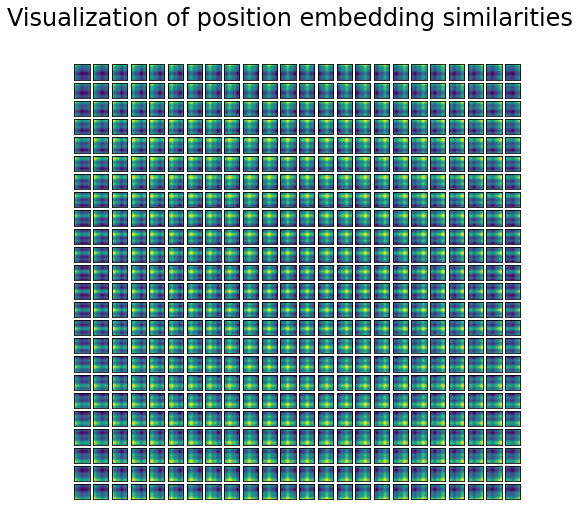

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
model_name = 'vit_base_patch16_384'
image_size = 384
num_classes = 1000
model = vision_transformer(model_name, num_classes).to(device)

ckpt = torch.load(f'./hw3_1.pth', map_location='cpu')
model.load_state_dict(ckpt['model'])

pos_embed = model.vit.pos_embed

# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((24, 24)).detach().cpu().numpy()
    ax = fig.add_subplot(24, 24, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

# Attention map

In [ ]:
img_1 = './hw3_data/p1_data/val/26_5064.jpg'
img_2 = './hw3_data/p1_data/val/29_4718.jpg'
img_3 = './hw3_data/p1_data/val/31_4838.jpg'
input_img = img_2

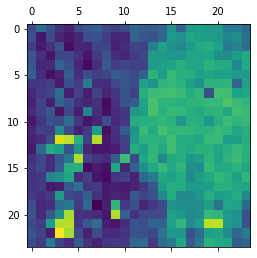

In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
x = Image.open(input_img).convert('RGB')
x = train_transforms(x).unsqueeze(0).to(device)
with torch.no_grad():
    x = model.vit.patch_embed(x)
    x = torch.cat((model.vit.cls_token, x), dim=1) + pos_embed
    for i in range(len(model.vit.blocks) - 1):
        x = model.vit.blocks[i](x)
    x = model.vit.blocks[-1].norm1(x)
    x = model.vit.blocks[-1].attn.qkv(x).squeeze()
    # print(x.shape)
    # q = x[:, :768]
    # k = x[:, 768:768 * 2]
    # attention_matrix = q @ k.T
    # print(attention_matrix.shape)
    x = x.reshape(577, 3, 768)
    q = x[:, 0]
    k = x[:, 1]
    # print(q.shape)
    # print(k.T.shape)
    # kT = k.permute(0, 2, 1)
    attention_matrix = q @ k.T
    # print(attention_matrix.shape)
    # print(attention_matrix)
    y = torch.mean(attention_matrix, dim=0)
    # print(y)
    # # y = torch.mean(y, dim=0)
    # # print(y.shape)
    attn_heatmap = y[1:].reshape((24, 24)).detach().cpu().numpy()

    attn_heatmap -= np.min(attn_heatmap)
    attn_heatmap /= np.max(attn_heatmap)
    # print(attn_heatmap)

    # # plt.matshow(attn_heatmap.squeeze())
    # # print(attn_heatmap.shape)
    # # plt.show(attn_heatmap)
    
    plt.matshow(attn_heatmap.squeeze())

In [ ]:
# import cv2
# heatmap = cv2.resize(attn_heatmap / attn_heatmap.max(), (224, 224))
# heatmap = np.uint8(255 * heatmap)
# heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# # print(heatmap)
# # plt.imshow(heatmap)
# superimposed_img = heatmap * 0.3 + Image.open(img_1).resize((224, 224))
# superimposed_img %= 256
# superimposed_img /= superimposed_img.max()
# # print(superimposed_img)
# plt.imshow(superimposed_img)


import cv2
img = cv2.imread(input_img)
heatmap = cv2.resize(attn_heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
print(heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# print(heatmap)
superimposed_img = heatmap * 0.4 + img * 0.6
# superimposed_img = heatmap
cv2.imwrite('./map.jpg', superimposed_img)


[[55 55 55 ... 86 86 86]
 [55 55 55 ... 86 86 86]
 [55 55 55 ... 86 86 86]
 ...
 [56 56 56 ... 82 82 82]
 [56 56 56 ... 82 82 82]
 [56 56 56 ... 82 82 82]]


True